In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial

from mutspec.utils.annot import mutations_summary, calculate_mutspec
from mutspec.utils import possible_codons

## Load mutations

In [2]:
path_to_mutations_simple = "../data/processed/nematoda/dif_approaches/simple/mutations.tsv"

mut_simple = pd.read_csv(path_to_mutations_simple, sep='\t')
mut_simple["MutBase"] = mut_simple["Mut"].str.slice(2, 5)
print(mut_simple.shape)
mut_simple.head()

(98584, 12)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene,MutBase
0,T[T>G]T,0,6,3,ATT,ATG,I,M,Node4,Node5,ATP6,T>G
1,A[A>G]G,0,163,1,AGT,GGT,S,G,Node4,Node5,ATP6,A>G
2,A[G>A]T,0,208,1,GTT,ATT,V,I,Node4,Node5,ATP6,G>A
3,T[A>T]T,0,241,1,ATA,TTA,M,L,Node4,Node5,ATP6,A>T
4,T[A>T]A,0,274,1,AAT,TAT,N,Y,Node4,Node5,ATP6,A>T


In [3]:
path_to_mutations_proba = "../data/processed/nematoda/dif_approaches/iqtree/mutations.tsv"

mut_proba = pd.read_csv(path_to_mutations_proba, sep='\t')
mut_proba["MutBase"] = mut_proba["Mut"].str.slice(2, 5)
print(mut_proba.shape)
mut_proba.head()

(11336085, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,A[A>T]T,0,4,1,ATG,TTG,M,L,0.223653,0.025558,0.017733,Node4,Node5,ATP6,A>T
1,A[T>A]T,0,4,1,TTG,ATG,L,M,0.074923,0.016245,0.011271,Node4,Node5,ATP6,T>A
2,A[A>T]T,0,4,1,ATT,TTT,I,F,0.266994,0.025577,0.017746,Node4,Node5,ATP6,A>T
3,A[T>A]T,0,4,1,TTT,ATT,F,I,0.089443,0.016258,0.011280,Node4,Node5,ATP6,T>A
4,G[A>T]T,0,4,1,ATG,TTG,M,L,0.046939,0.001242,0.000862,Node4,Node5,ATP6,A>T


In [4]:
path_to_mutations_pastml = "../data/processed/nematoda/dif_approaches/pastml/mutations.tsv"

mut_pastml = pd.read_csv(path_to_mutations_pastml, sep='\t')
mut_pastml["MutBase"] = mut_pastml["Mut"].str.slice(2, 5)
print(mut_pastml.shape)
mut_pastml.head()

(3615949, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,G[T>A]A,0,53,2,GTA,GAA,V,E,0.054248,0.001046,0.001046,Node4,Node5,ATP6,T>A
1,T[T>A]A,-1,53,2,TTA,TAA,L,*,0.072780,0.002390,0.002390,Node4,Node5,ATP6,T>A
2,T[T>G]A,0,53,2,TTA,TGA,L,W,0.072780,0.000913,0.000913,Node4,Node5,ATP6,T>G
3,T[T>A]G,-1,53,2,TTG,TAG,L,*,0.029787,0.000400,0.000400,Node4,Node5,ATP6,T>A
4,G[A>G]T,0,53,2,GAT,GGT,D,G,0.012598,0.000448,0.000448,Node4,Node5,ATP6,A>G


### Simple

In [5]:
mutations_summary(mut_simple, "Gene")

,non-syn,syn,syn4f,Stop loss,Stop gain
Gene,,,,,
ATP6,1932,1562,1668,3,2
COX1,2338,4939,6444,3,1
COX2,1593,2325,2283,1,0
COX3,2030,2563,2928,4,0
CYTB,3432,3632,3998,4,3
ND1,2763,2954,3036,6,2
ND2,3861,2723,1851,5,4
ND3,1290,1088,863,3,0
ND4,4451,4024,4173,7,2


### Proba iqtree with evol coef

In [6]:
msum_pr = mutations_summary(mut_proba, "Gene", "ProbaFull")
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,5679.8,2106.0,2146.4,142.9,139.9,12.7
COX1,4079.1,5838.1,7373.2,60.4,58.4,3.9
COX2,3736.8,2919.0,2615.1,71.7,69.6,5.8
COX3,3128.3,3129.0,3426.2,40.5,36.4,2.5
CYTB,4998.0,4388.7,4715.7,52.1,46.6,3.0
ND1,4631.3,3644.5,3700.0,62.2,58.0,3.4
ND2,8161.2,3710.9,2393.9,96.0,88.6,8.4
ND3,2160.8,1393.7,1080.7,29.4,27.0,2.4
ND4,6087.4,4894.2,5128.6,43.4,34.8,4.0


In [7]:
mut_proba.ProbaFull.max()

0.99935335

In [8]:
mut_proba[mut_proba.ProbaFull > 0.95]

,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
1852940,G[T>A]A,0,191,2,GTA,GAA,V,E,0.979450,0.979450,0.978953,Node9,Meloidogyne_arenaria,ATP6,T>A
1852950,G[A>C]G,2,450,3,AGA,AGC,S,S,0.963150,0.963150,0.962661,Node9,Meloidogyne_arenaria,CYTB,A>C
1852954,T[A>G]T,1,1149,3,ATA,ATG,M,M,0.953350,0.953350,0.952866,Node9,Meloidogyne_arenaria,ND2,A>G
1852955,C[A>G]T,2,396,3,TCA,TCG,S,S,0.950530,0.950530,0.950047,Node9,Meloidogyne_arenaria,ND4,A>G
1977220,T[A>T]C,0,208,1,ACT,TCT,T,S,0.987831,0.985579,0.951448,Node15,Node16,COX2,A>T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335990,G[T>C]C,2,966,3,GGT,GGC,G,G,0.966321,0.966321,0.955565,Node94,Cylicocyclus_ashworthi,ND5,T>C
11336064,G[A>G]T,1,201,3,TGA,TGG,W,W,0.977335,0.977335,0.966457,Node94,Cylicocyclus_ashworthi,ND6,A>G
11336065,T[A>G]A,1,231,3,TTA,TTG,L,L,0.977665,0.977665,0.966783,Node94,Cylicocyclus_ashworthi,ND6,A>G
11336067,G[G>T]A,2,237,3,GGG,GGT,G,G,0.992121,0.992121,0.981078,Node94,Cylicocyclus_ashworthi,ND6,G>T


In [9]:
mut_proba[mut_proba.ProbaFull < 0.05].ProbaFull.sum()

31594.034184262226

In [10]:
mut_proba[mut_proba.ProbaFull > 0.75].ProbaFull.sum()

47507.496807150004

In [11]:
mut_proba[
    (mut_proba.ProbaFull > 0.25) & 
    (mut_proba.ProbaFull < 0.5)
].ProbaFull.sum()

15490.74760182

In [12]:
mut_proba[
    (mut_proba.ProbaFull > 0.5) & 
    (mut_proba.ProbaFull < 0.75)
].ProbaFull.sum()

16667.39759304

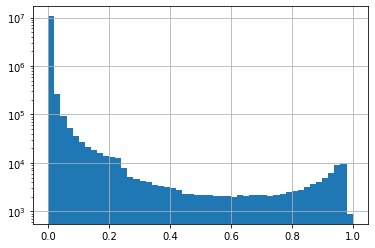

In [13]:
mut_proba.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.show()

### Proba pastml

In [14]:
msum_pr = mutations_summary(mut_pastml, "Gene", "ProbaFull")
msum_pr["syn"] += msum_pr["syn4f"]
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,2113.6,6021.9,3314.8,16.3,5.9,0.3
COX1,2654.4,25965.5,15134.5,7.3,3.0,0.1
COX2,1795.3,10162.4,4985.8,13.7,4.6,0.8
COX3,2358.8,12416.7,6635.8,14.2,5.3,0.3
CYTB,4038.0,17189.6,9234.2,25.4,9.7,1.0
ND1,3468.2,13221.9,6864.5,14.7,4.8,0.3
ND2,4982.3,9076.2,3554.3,24.7,8.1,0.5
ND3,1649.6,3875.8,1666.3,7.8,3.4,0.1
ND4,5582.5,18137.7,9321.7,25.0,8.9,1.1


In [15]:
msum_pr = mutations_summary(mut_proba, "Gene", "ProbaFull")
msum_pr["syn"] += msum_pr["syn4f"]
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,5679.8,4252.3,2146.4,142.9,139.9,12.7
COX1,4079.1,13211.3,7373.2,60.4,58.4,3.9
COX2,3736.8,5534.1,2615.1,71.7,69.6,5.8
COX3,3128.3,6555.2,3426.2,40.5,36.4,2.5
CYTB,4998.0,9104.4,4715.7,52.1,46.6,3.0
ND1,4631.3,7344.5,3700.0,62.2,58.0,3.4
ND2,8161.2,6104.8,2393.9,96.0,88.6,8.4
ND3,2160.8,2474.4,1080.7,29.4,27.0,2.4
ND4,6087.4,10022.7,5128.6,43.4,34.8,4.0


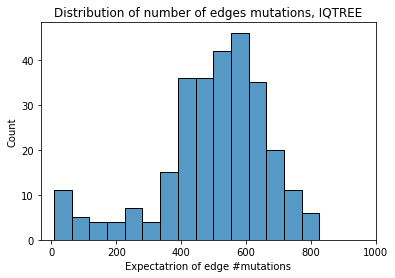

In [16]:
sns.histplot(mut_proba.groupby("AltNode").ProbaFull.sum())
plt.title("Distribution of number of edges mutations, IQTREE")
plt.xlabel("Expectatrion of edge #mutations")
plt.xlim(None, 1000)
plt.show()

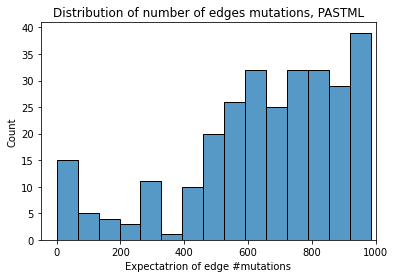

In [17]:
sns.histplot(mut_pastml.groupby("AltNode").ProbaFull.sum(), bins=15)
plt.title("Distribution of number of edges mutations, PASTML")
plt.xlabel("Expectatrion of edge #mutations")
plt.xlim(None, 1000)
plt.show()

## Mutspec

In [5]:
# mutspec_simple = pd.read_csv("../data/processed/nematoda/30-05-22-16-39-29_rooted/mutspec192.tsv", sep='\t')
# mutspec_proba  = pd.read_csv("../data/processed/nematoda/proba/mutspec192.csv", sep='\t')
# mutspec_pastml = pd.read_csv("../data/processed/nematoda/pastml/mutspec192.csv", sep='\t')

mutspec_simple = pd.read_csv("../data/processed/nematoda/dif_approaches/simple/mutspec192.tsv", sep='\t')
mutspec_proba  = pd.read_csv("../data/processed/nematoda/dif_approaches/iqtree/mutspec192.tsv", sep='\t')
mutspec_pastml = pd.read_csv("../data/processed/nematoda/dif_approaches/pastml/mutspec192.tsv", sep='\t')

### Collapse to 96

In [6]:
translator = str.maketrans("ACGT", "TGCA")


def rev_comp(mut: str):
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut


def collapse_mutspec(ms192: pd.DataFrame):
    assert ms192.shape[0] == 192
    ms1 = ms192[ms192.Mut.str.get(2).isin(list("CT"))]
    ms2 = ms192[ms192.Mut.str.get(2).isin(list("AG"))]
    ms2["Mut"] = ms2["Mut"].apply(rev_comp)

    ms96 = pd.concat([ms1, ms2]).groupby("Mut")[["ObsFr", "ExpFr"]].sum()
    ms96["RawMutSpec"] = ms96["ObsFr"] / ms96["ExpFr"]
    ms96["MutSpec"] = ms96["RawMutSpec"] / ms96["RawMutSpec"].sum()
    ms96 = ms96.fillna(0)
    return ms96

In [7]:
mutspec_simple = mutspec_simple.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
mutspec_proba = mutspec_proba.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
mutspec_pastml = mutspec_pastml.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()

### Fulctions for plotting

TODO replace by AlexandrovLab functions

In [8]:
tmp_df = pd.DataFrame({"MutExt": mutspec_simple[mutspec_simple.Label == "ff"].Mut.unique()})
tmp_df["Mut"] = tmp_df.MutExt.str.get(2) + ">" + tmp_df.MutExt.str.get(4)
tmp_df["Context"] = tmp_df.MutExt.str.get(
    0) + tmp_df.MutExt.str.get(2) + tmp_df.MutExt.str.get(-1)
tmp_df.sort_values(["Mut", "Context"], inplace=True)
order96 = tmp_df.MutExt.values
order96.shape

(96,)

In [9]:
from itertools import groupby

import warnings
warnings.filterwarnings("ignore")

coloring = {
    "C>A": "lightblue",
    "C>G": "black",
    "C>T": "red",
    "T>A": "gray",
    "T>C": "green",
    "T>G": "pink",
}


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black', linewidth=1)
    line.set_clip_on(False)
    ax.add_line(line)


def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def label_group_bar_table(ax, df):
    font = {
        'family': 'cursive',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
    }
    rotation = 90
    ypos = -.04
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        if level == 0:
            rotation = 0
            font['size'] = 12

        pos = 0
        for label, rpos in label_len(df.index, level):
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', rotation=rotation,
                    fontdict=font, transform=ax.transAxes)
            if level == 0:
                add_line(ax, pos*scale, ypos)
            pos += rpos
        if level == 0:
            add_line(ax, pos*scale, ypos)
        ypos -= .05


def plot_mutspec192(edge_mutspec, label="Mutational spectra", filepath=None):
    edge_mutspec = edge_mutspec.copy()
    smpl = edge_mutspec.groupby("AltNode").get_group(edge_mutspec.AltNode.sample().item()).sort_values(["MutBase", "Context"])
    colors = smpl["MutBase"].map(coloring).values
    df = edge_mutspec.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.barplot(
        x="Mut", y="MutSpec", data=edge_mutspec, 
        order=order96, errwidth=1, ax=fig.gca()
    )
    for bar, clr in zip(ax.patches, colors):
        bar.set_color(clr)
        bar.set_width(0.6)
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(label)
    label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath)
    plt.show()

In [7]:
mutspec_simple["MutBase"] = mutspec_simple.Mut.str.slice(2, 5)
mutspec_simple["Context"] = mutspec_simple.Mut.str.get(0) + mutspec_simple.Mut.str.get(2) + mutspec_simple.Mut.str.get(-1)

mutspec_proba["MutBase"] = mutspec_proba.Mut.str.slice(2, 5)
mutspec_proba["Context"] = mutspec_proba.Mut.str.get(0) + mutspec_proba.Mut.str.get(2) + mutspec_proba.Mut.str.get(-1)

mutspec_pastml["MutBase"] = mutspec_pastml.Mut.str.slice(2, 5)
mutspec_pastml["Context"] = mutspec_pastml.Mut.str.get(0) + mutspec_pastml.Mut.str.get(2) + mutspec_pastml.Mut.str.get(-1)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


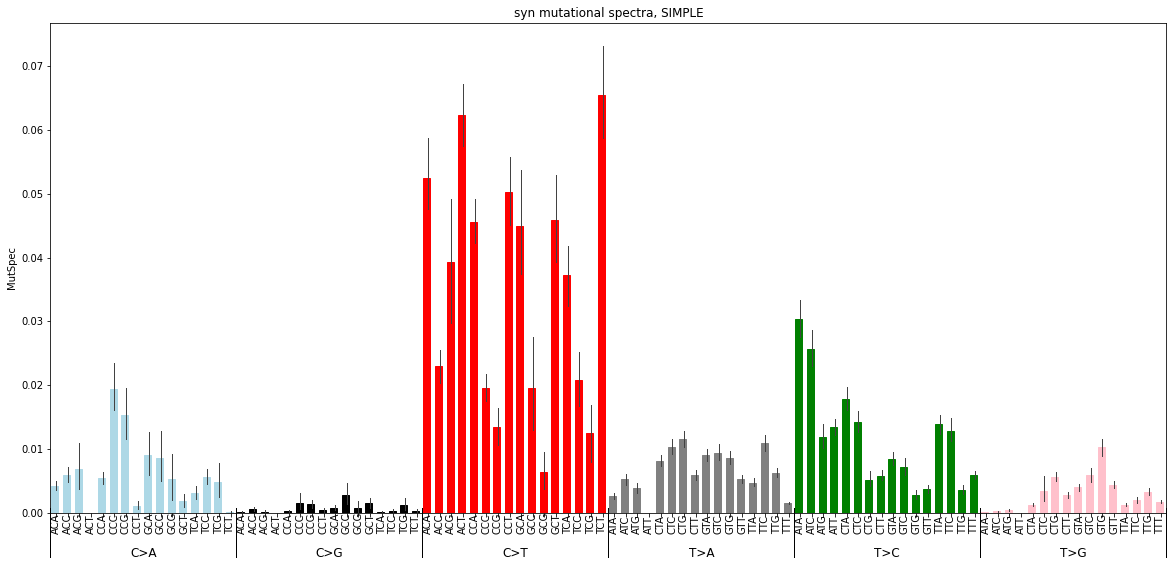

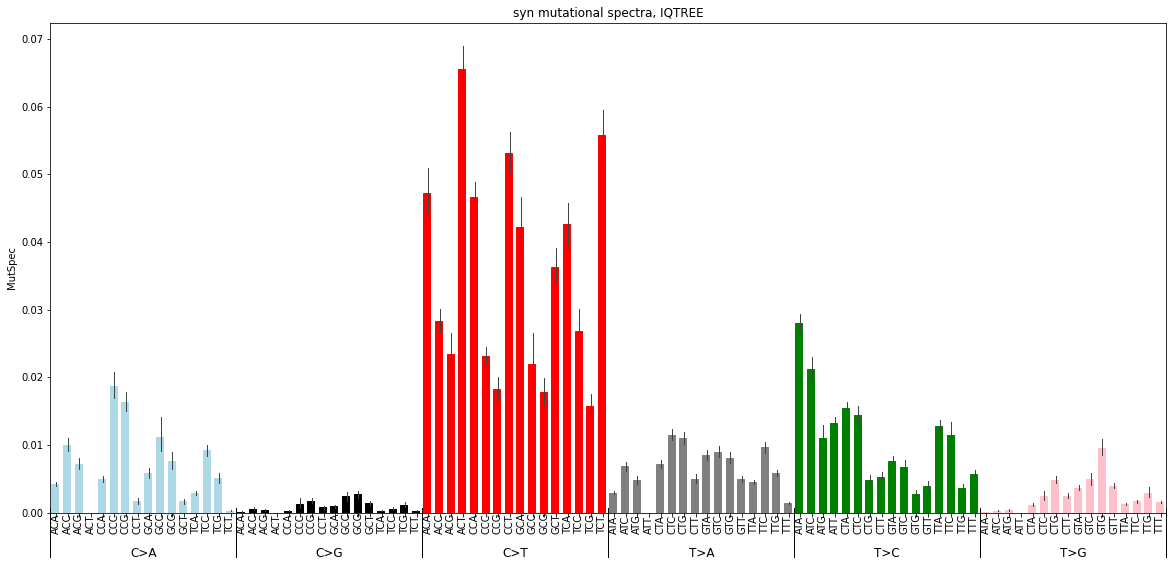

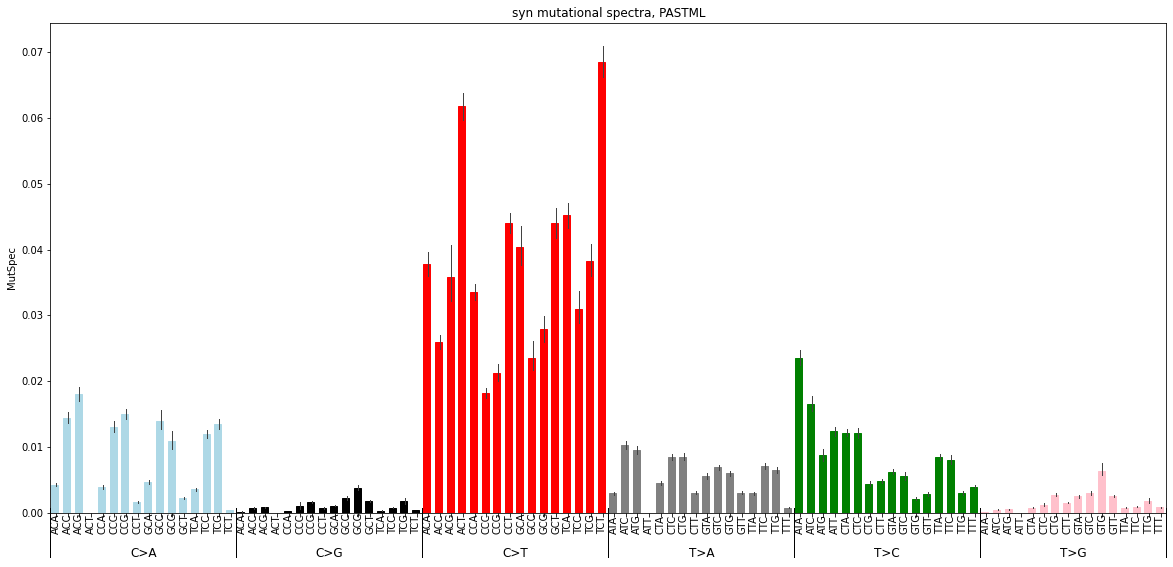

In [8]:
lbl = "syn"
plot_mutspec192(mutspec_simple[mutspec_simple.Label == lbl], f"{lbl} mutational spectra, SIMPLE")
plot_mutspec192(mutspec_proba[mutspec_proba.Label   == lbl], f"{lbl} mutational spectra, IQTREE")
plot_mutspec192(mutspec_pastml[mutspec_pastml.Label == lbl], f"{lbl} mutational spectra, PASTML")

In [10]:
sims_data = []
for lbl in mutspec_simple.Label.unique():
    for anode in set(mutspec_simple.AltNode):
        df1 = mutspec_simple[(mutspec_simple.Label == lbl) & (mutspec_simple.AltNode == anode)].set_index("Mut").sort_index()
        df2 = mutspec_proba[(mutspec_proba.Label == lbl)   & (mutspec_proba.AltNode == anode) ].set_index("Mut").sort_index()
        df3 = mutspec_pastml[(mutspec_pastml.Label == lbl) & (mutspec_pastml.AltNode == anode)].set_index("Mut").sort_index()

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data.append({
            "Label": "syn4f" if lbl == "ff" else lbl, 
            "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df = pd.DataFrame(sims_data).sort_values("Label")

In [11]:
sims_df

,Label,AltNode,cossim simple&iqtree,cossim simple&pastml,cossim iqtree&pastml
0,all,Halicephalobus_mephisto,0.966675,0.617154,0.722365
179,all,Meloidogyne_javanica,0.996211,0.816039,0.812205
180,all,Node17,0.829603,0.527229,0.746290
181,all,Metastrongylus_pudendotectus,0.955440,0.872871,0.941209
182,all,Aphelenchoides_besseyi,0.942597,0.687203,0.808262
...,...,...,...,...,...
470,syn4f,Onchocerca_volvulus,0.899614,0.605990,0.728237
471,syn4f,Anisakis_pegreffii,0.973838,0.414574,0.520763
472,syn4f,Node96,0.678767,0.436267,0.844887
466,syn4f,Node45,0.779243,0.558283,0.880796


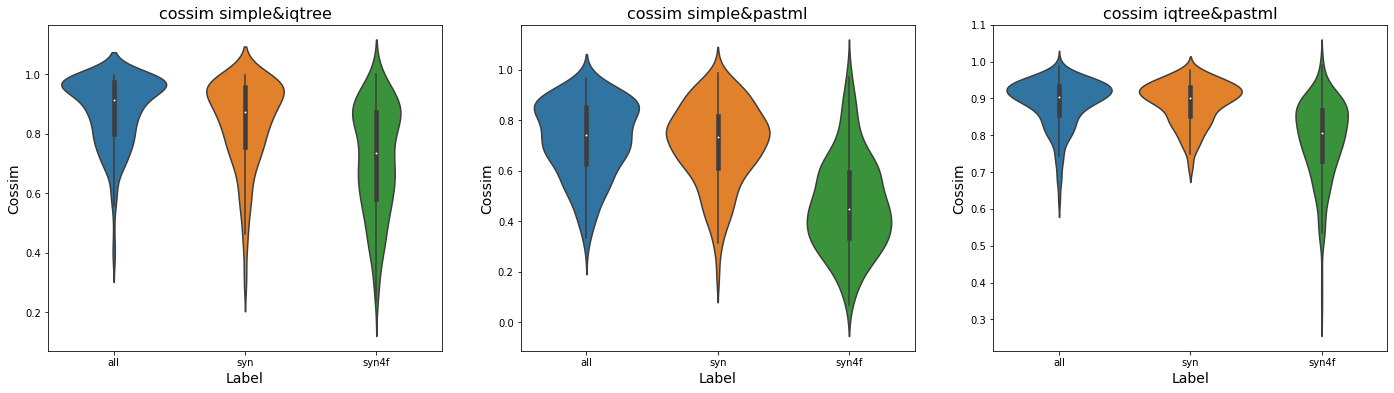

In [12]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
for i, cs_col in enumerate(sims_df.columns[-3:]):
    axs[i].set_xlabel(None, fontsize=14)
    axs[i].set_title(cs_col, fontsize=16)
    sns.violinplot(y=cs_col, x="Label", data=sims_df, ax=axs[i], fontdict={"fontsize": 16})
    axs[i].set_ylabel("Cossim", fontsize=14)
    

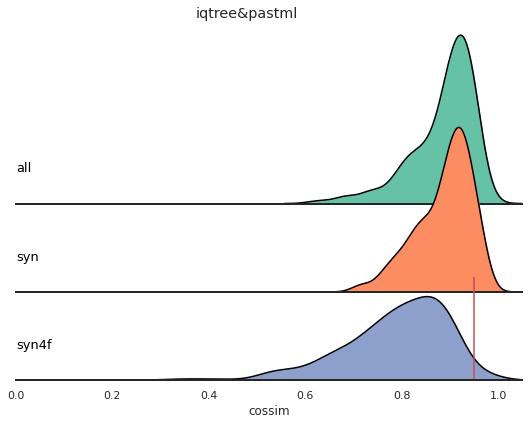

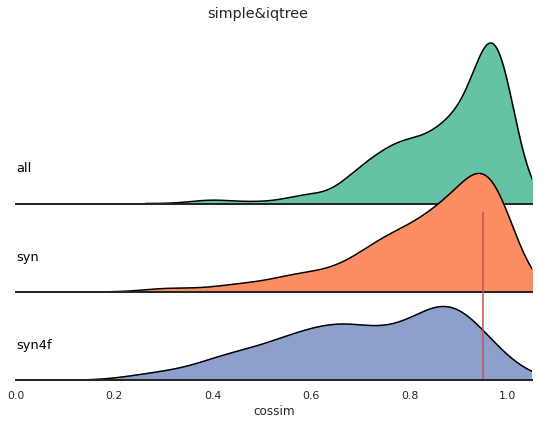

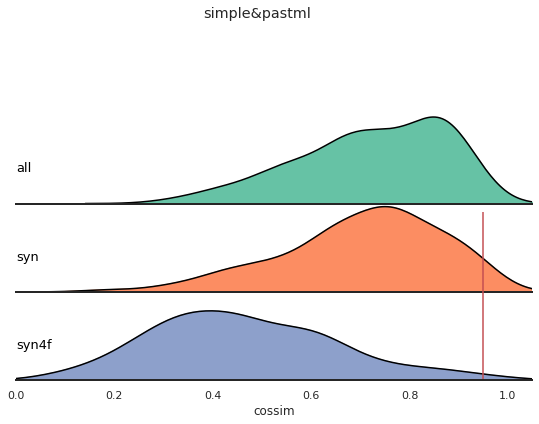

In [49]:
# https://python.plainenglish.io/ridge-plots-with-pythons-seaborn-4de5725881af
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
for cs_col in sorted(sims_df.columns[-3:]):
    g = sns.FacetGrid(sims_df, palette=palette, row="Label", hue="Label", aspect=4, height=2.0)
    g.map_dataframe(sns.kdeplot, x=cs_col, fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x=cs_col, color='black')

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        
    g.map(label, "Label")
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="cossim", ylabel="")
    g.despine(left=True)
    plt.suptitle(cs_col.split()[1], y=0.98)
    plt.vlines([0.95], 0, 5, 'r')
    plt.xlim(0, 1.05)
    plt.show()

## Categorizing mutations
We need to explore what mutations sample is responible for the bias

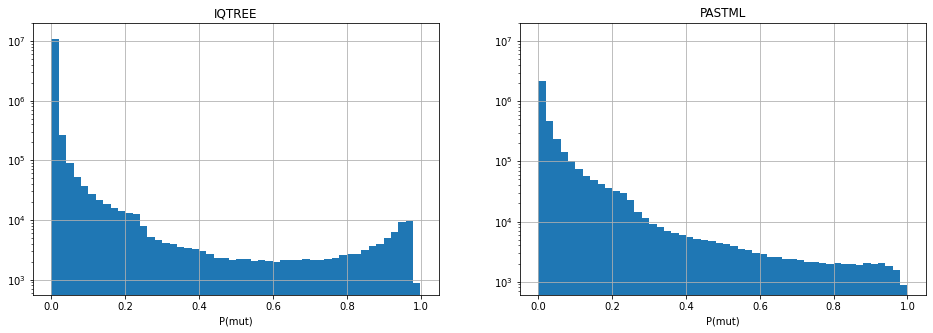

In [55]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
mut_proba.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("IQTREE")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)

plt.subplot(1,2,2)
mut_pastml.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("PASTML")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)
plt.show()

Сколько мутаций в каждом интервале вероятностей у обоих подходов

In [14]:
print("p1\tp2\t#iqtree\t#pastml")
for x1 in np.linspace(0, 1, 21)[:-1]:
    x2 = x1 + 0.05
    mut_exp_num_iqtree = mut_proba[(mut_proba.ProbaFull > x1) & (mut_proba.ProbaFull <= x2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > x1) & (mut_pastml.ProbaFull <= x2)].ProbaFull.sum()
    print(f"{x1:.2f}\t{x2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

p1	p2	#iqtree	#pastml
0.00	0.05	31594.0	31738.3
0.05	0.10	8923.4	24386.0
0.10	0.15	7130.4	19384.6
0.15	0.20	6758.6	17346.9
0.20	0.25	6779.3	16573.9
0.25	0.30	3539.3	9695.3
0.30	0.35	3234.5	6744.7
0.35	0.40	3133.0	5947.6
0.40	0.45	2946.4	5570.4
0.45	0.50	2637.5	5458.3
0.50	0.55	2858.5	5175.0
0.55	0.60	2977.8	4648.9
0.60	0.65	3283.1	4233.7
0.65	0.70	3617.9	4010.3
0.70	0.75	3930.0	3996.0
0.75	0.80	4593.0	3932.7
0.80	0.85	5709.4	4057.6
0.85	0.90	8191.3	4342.5
0.90	0.95	14308.2	4603.3
0.95	1.00	14705.6	3203.3


Распределения сильно отличаются

### Load genomes trinucleotide freqs

In [15]:
path_to_freqs_simple = "../data/processed/nematoda/dif_approaches/simple/freqs.tsv"
path_to_freqs_iqtree = "../data/processed/nematoda/dif_approaches/iqtree/freqs.tsv"
path_to_freqs_pastml = "../data/processed/nematoda/dif_approaches/pastml/freqs.tsv"

freqs_simple = pd.read_csv(path_to_freqs_simple, sep='\t').drop_duplicates()
freqs_iqtree = pd.read_csv(path_to_freqs_iqtree, sep='\t').drop_duplicates()
freqs_pastml = pd.read_csv(path_to_freqs_pastml, sep='\t').drop_duplicates()

In [16]:
freqs_simple.shape, freqs_iqtree.shape, freqs_pastml.shape

((5112, 71), (5112, 71), (5112, 71))

In [17]:
freqs_pastml.head()

,Node,Gene,Label,A,C,G,T,AAA,AAC,AAG,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,Node4,ATP6,all,70.625336,18.667410,55.608257,173.132300,5.095702,1.286621,3.864777,...,1.554956,3.631240,7.424756,1.598857,5.004561,12.834096,19.419708,3.875603,14.194652,62.031143
1,Node4,ATP6,syn,32.322359,3.771173,22.724494,112.307452,1.635471,0.035757,0.781419,...,0.188912,1.042380,4.011391,0.787979,2.967173,5.035453,11.269019,2.303265,8.327558,30.141795
2,Node4,ATP6,ff,6.166733,0.663753,4.184312,21.216852,0.000000,0.000000,0.000000,...,0.023173,0.074031,0.495502,0.089458,0.534053,0.819981,1.036346,0.289068,1.252701,3.859288
3,Node4,COX1,all,231.328450,106.951065,211.987030,481.753170,9.451550,7.232484,9.898535,...,5.097630,14.176530,19.769630,11.308639,32.417683,31.216570,52.758630,15.447796,45.120945,121.308160
4,Node4,COX1,syn,118.845732,20.681036,83.434265,443.449536,2.301157,1.800367,2.497267,...,0.954692,4.321755,9.843034,3.788407,12.504039,14.786200,33.226070,8.891206,27.556972,74.462793


In [60]:
def calc_tree_mutspec(mut, freqs, lbl="syn", pmin=0.0, pmax=1.0):
    """
    calculate tree mutspec from history files
    
    return 96comp mutspec of each edge in one table
    """
    # sample mutations
    mut = mut[(mut.ProbaFull > pmin) & (mut.ProbaFull <= pmax)]
    
    mutspec = []
    for (ref_node, alt_node), cur_mut in mut.groupby(["RefNode", "AltNode"]):
        # sample freqs
        _cur_freq_df = freqs[(freqs.Node == ref_node) & (freqs.Label == lbl)]
        cur_freq = _cur_freq_df[possible_codons].sum(axis=0).to_dict()

        # calculate mutspec
        ms192 = calculate_mutspec(cur_mut, cur_freq, lbl, True, True)
        ms192["RefNode"] = ref_node
        ms192["AltNode"] = alt_node
        ms192["Label"] = lbl
        mutspec.append(ms192)
    mutspec_df = pd.concat(mutspec)
    mutspec_df = mutspec_df.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
    mutspec_df["MutBase"] = mutspec_df.Mut.str.slice(2, 5)
    mutspec_df["Context"] = mutspec_df.Mut.str.get(0) + mutspec_df.Mut.str.get(2) + mutspec_df.Mut.str.get(-1)
    return mutspec_df

In [45]:
space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]

In [46]:
for p1, p2 in zip(space[:-1], space[1:]):
    mut_exp_num_iqtree = mut_proba[(mut_proba.ProbaFull > p1) & (mut_proba.ProbaFull <= p2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > p1) & (mut_pastml.ProbaFull <= p2)].ProbaFull.sum()
    print(f"{p1:.2f}\t{p2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

0.00	0.05	31594.0	31738.3
0.05	0.30	33130.9	87386.8
0.30	0.50	11951.4	23720.9
0.50	0.80	21260.4	25996.4
0.80	1.00	42914.5	16206.7


In [61]:
ms_cat_iqtree = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_proba, freqs_iqtree, "syn", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_iqtree.append(ms)

ms_cat_iqtree_df = pd.concat(ms_cat_iqtree)

In [62]:
ms_cat_pastml = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_pastml, freqs_pastml, "syn", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_pastml.append(ms)

ms_cat_pastml_df = pd.concat(ms_cat_pastml)

### Categorized mutspec 

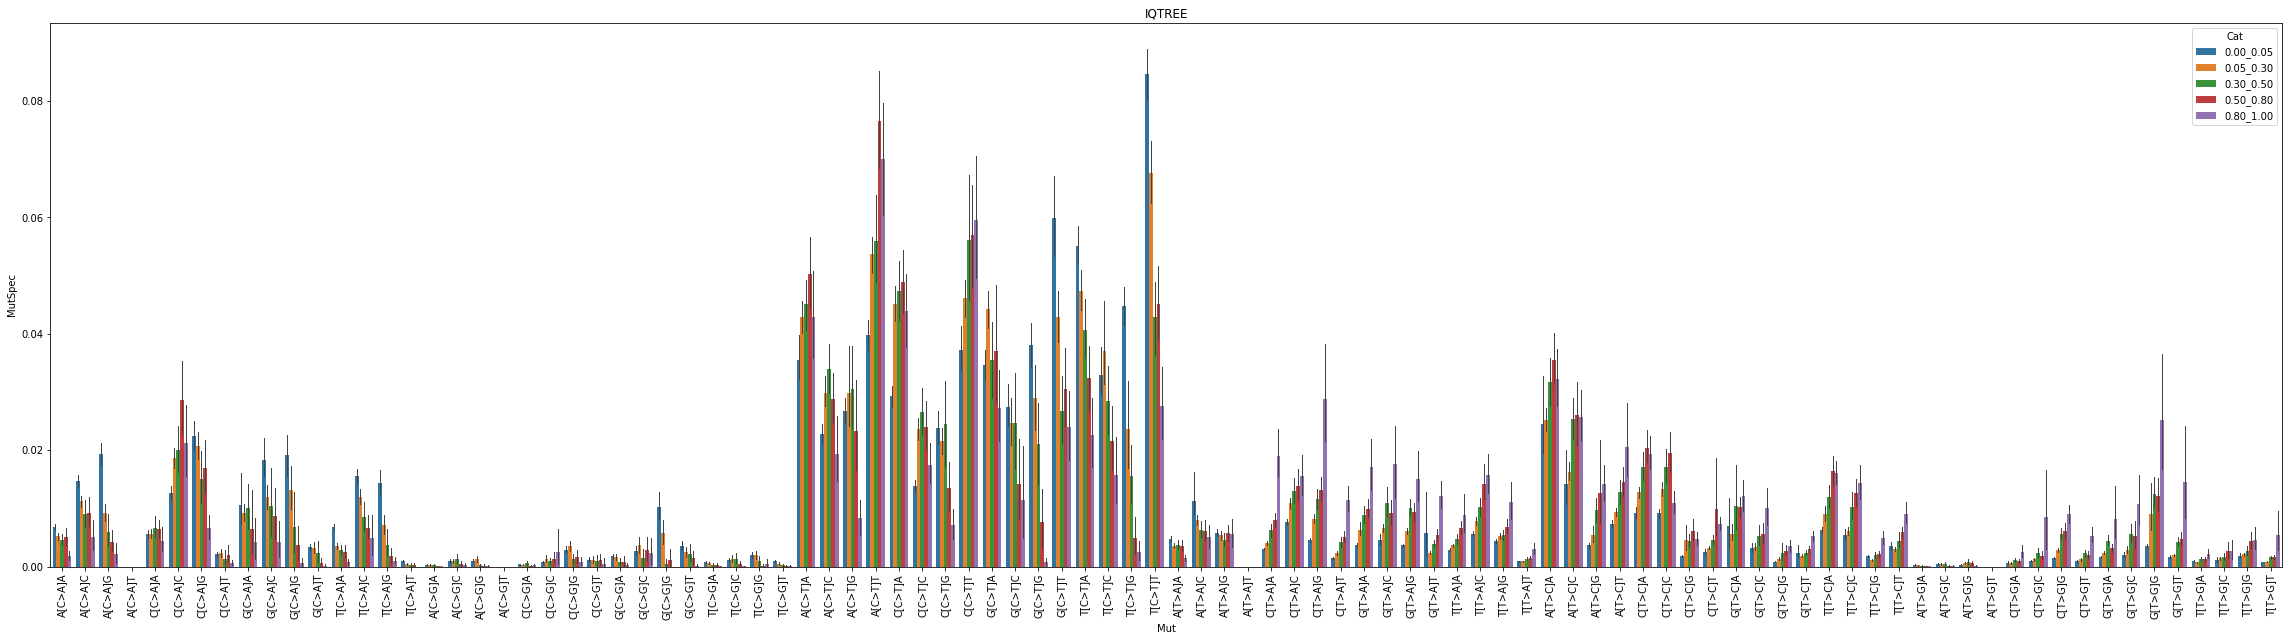

In [63]:
plt.figure(figsize=(40, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_iqtree_df, errwidth=1, order=order96
)
plt.title("IQTREE")
plt.xticks(rotation=90);

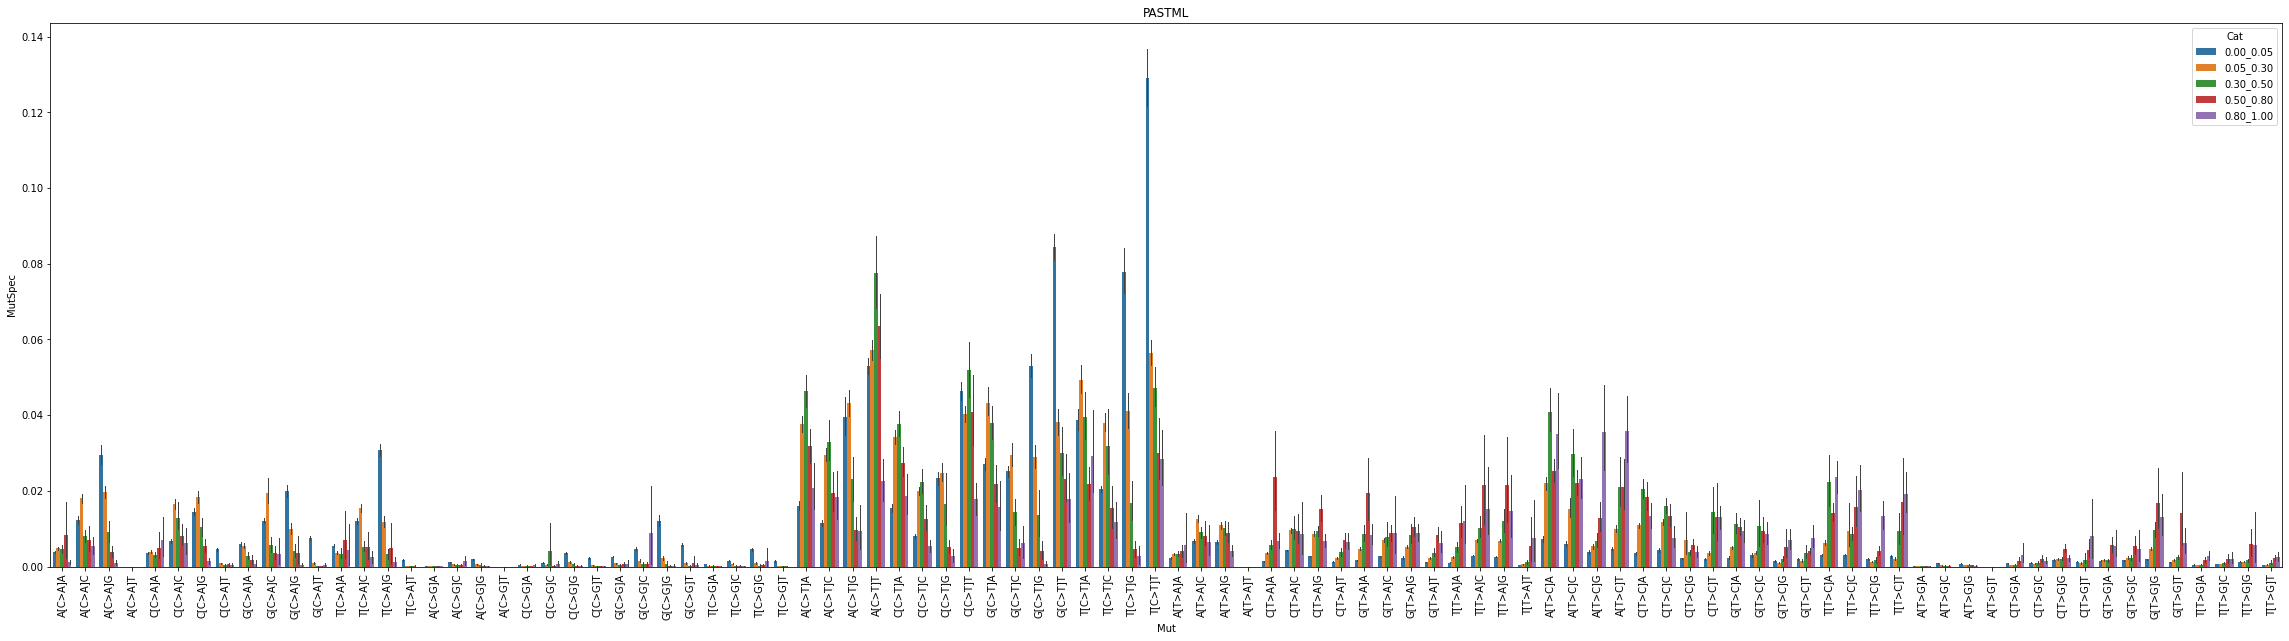

In [64]:
plt.figure(figsize=(40, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_pastml_df, errwidth=1, order=order96
)
plt.title("PASTML")
plt.xticks(rotation=90);

Разглядывать сложно. Но виден сильный дисбаланс.Как по низковероятным мутациям, так и по высоковероятным

### Compare cossim of mutspecs on mutations samples

In [117]:
def plot_compared(p1, p2, constant_pastml=False):
    lbl = "syn"
    ms_iqtree = calc_tree_mutspec(mut_proba,  freqs_iqtree, lbl, p1, p2)
    if constant_pastml:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, 0, 1)
    else:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, p1, p2)
    sims_data = []
    for anode in set(mutspec_simple.AltNode):
        df1 = mutspec_simple[(mutspec_simple.Label == lbl) & (mutspec_simple.AltNode == anode)].set_index("Mut").sort_index()
        df2 = ms_iqtree[(ms_iqtree.AltNode == anode)].set_index("Mut").sort_index()
        df3 = ms_pastml[(ms_pastml.AltNode == anode)].set_index("Mut").sort_index()

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data.append({"AltNode": anode, "Pair": "simple & iqtree", "Cossim": sim12})
        sims_data.append({"AltNode": anode, "Pair": "iqtree & pastml", "Cossim": sim23})
        sims_data.append({"AltNode": anode, "Pair": "simple & pastml", "Cossim": sim13})

    sims_df = pd.DataFrame(sims_data)

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
    palette = sns.color_palette("Set2", 12)
    g = sns.FacetGrid(sims_df, palette=palette, row="Pair", hue="Pair", aspect=4, height=2.0)
    g.map_dataframe(sns.kdeplot, x="Cossim", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="Cossim", color='black')

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        
    g.map(label, "Pair")
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="cossim", ylabel="")
    g.despine(left=True)
    title = f"Proba: ({p1}, {p2}]"
    if constant_pastml:
        title = f"Proba: iqtree: ({p1}, {p2}]; pastml: (0, 1]"
    plt.suptitle(title, y=0.98)
    plt.vlines([0.95], 0, 5, 'r')
    plt.xlim(0, 1.05)
    plt.show()

Ниже графики, в которых мутспек считается по подвыборке мутаций с указанной вероятностью. 

Сначала идут графики, где мутации обрубались как для iqtree, так и для pastml. Далее идут графики, где мутации обрубаются только у iqtree

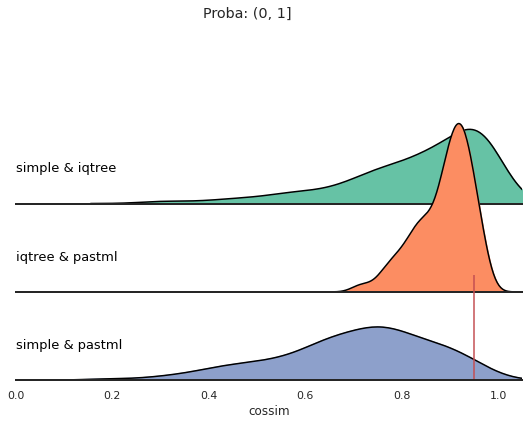

In [118]:
plot_compared(0, 1)

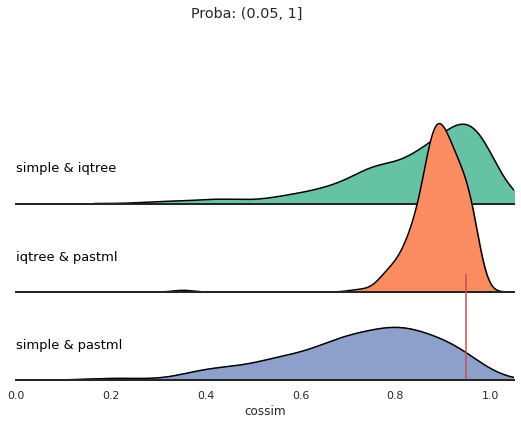

In [119]:
plot_compared(0.05, 1)

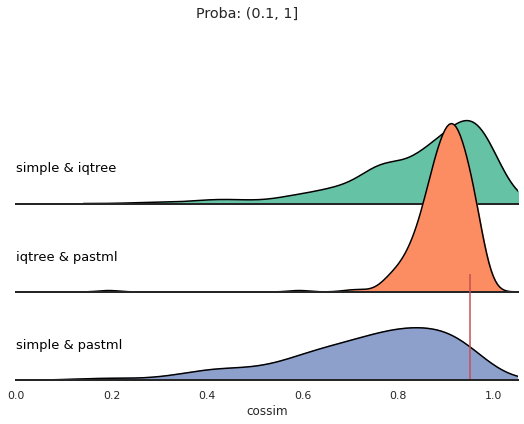

In [120]:
plot_compared(0.1, 1)

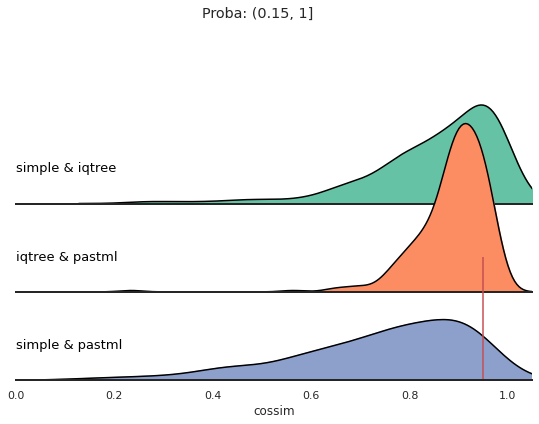

In [121]:
plot_compared(0.15, 1)

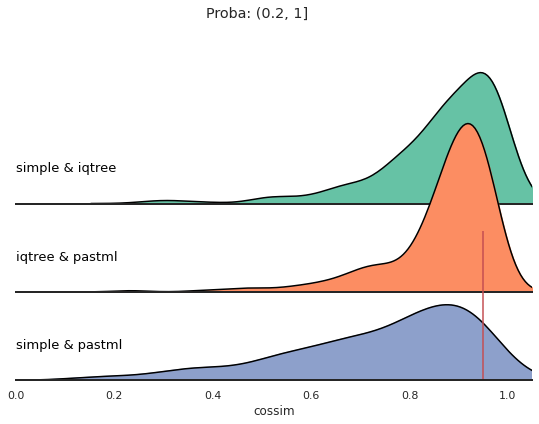

In [122]:
plot_compared(0.20, 1)

Далее полная выборка мутаций из pastml сравнивается с разными выборками из iqtree

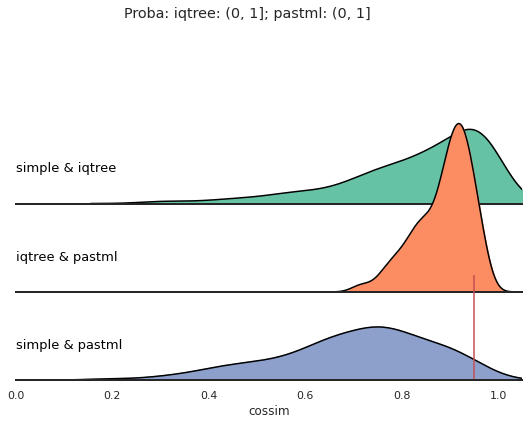

In [123]:
plot_compared(0, 1, True)

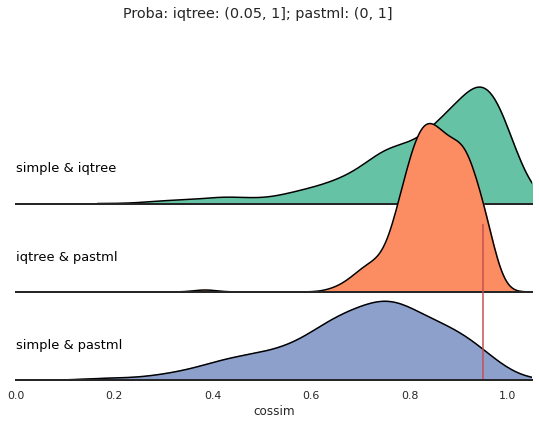

In [124]:
plot_compared(0.05, 1, True)

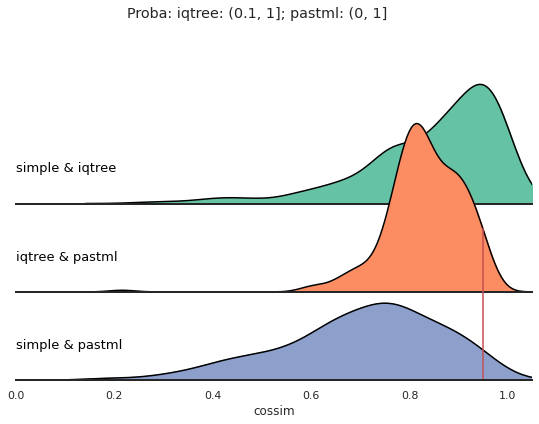

In [125]:
plot_compared(0.1, 1, True)

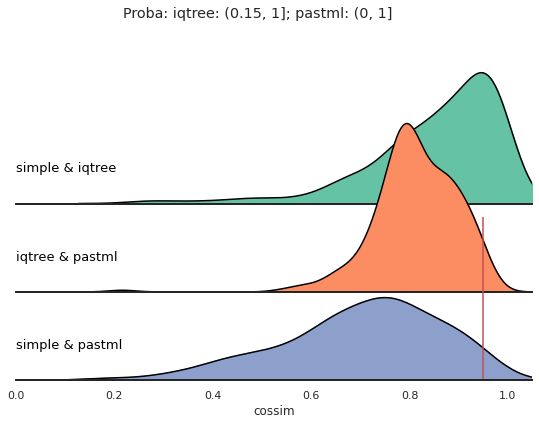

In [126]:
plot_compared(0.15, 1, True)